## Introducción
<!---
Debe explicar la base teórica de la funcionalidad presentada.
Tips: Que parte del tema HPC están cubriendo.
-->


La <strong>computación de alto rendimiento (HPC)</strong> representa la capacidad de procesar datos y realizar cálculos complejos a velocidades muy altas.[1]

Es a través de los datos que se hacen descubrimientos científicos innovadores, se alimentan las innovaciones que cambian los juegos y se mejora la calidad de vida de miles de millones de personas en todo el mundo. HPC es la base de los avances científicos, industriales y sociales.

Un subconjunto de la inteligencia artificial (IA), el aprendizaje automático (ML) es el área de la ciencia computacional que se centra en el análisis y la interpretación de patrones y estructuras de datos que hacen posible el aprendizaje, el razonamiento y la toma de decisiones sin interacción humana.[2] 

El Aprendizaje Automático (AA) consta de tres partes:

- El algoritmo computacional, situado en el núcleo de la toma de determinaciones.
- Las variables y las funciones que conforman la decisión.
- El conocimiento base según el cual se sabe la respuesta que permite aprender al sistema (lo entrena).

TensorFlow es una plataforma de código abierto de extremo a extremo para el aprendizaje automático. Cuenta con un ecosistema integral y flexible de herramientas, bibliotecas y recursos de la comunidad que les permite a los investigadores innovar con el aprendizaje automático y, a los desarrolladores, compilar e implementar con facilidad aplicaciones con tecnología de AA.[3] 

Keras es una API diseñada para seres humanos, no para máquinas. Keras sigue las mejores prácticas para reducir la carga cognitiva: ofrece API consistentes y simples, minimiza la cantidad de acciones del usuario necesarias para casos de uso comunes y proporciona mensajes de error claros y procesables.[4] 

## Armado del ambiente
<!---
En esta sección deben estar todos los comandos
previos, que son necesarios para la ejecución del ejercicio. 
-->

### Intalación de TensorFlow con GPU

In [ ]:
!pip install tensorflow-gpu

### Verificación de la Versión Instalada de TensorFlow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


### Configuración

In [ ]:
import os
import urllib.request
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

### Descarga el conjunto de datos

Se utilizan un conjunto de datos Flickr8K, el cual comprende más de 8.000 imágenes, cada una de las cuales está emparejada con cinco subtítulos diferentes.



In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

### Parametros

El parametro de entrenamiento **EPOCHS** es el m{as importante, ya que un número bajo genereá menos procesamiento pero es mayor el margen de error al asignarle un titulo a las imagenes. 

A la inversa, número alto genereá más procesamiento (siendo más lento) pero es menor el margen de error al asignarle un titulo a las imagenes. 


In [ ]:
# Ruta de las imagenes
IMAGES_PATH = "Flicker8k_Dataset"

# Dimension de las imagenes
IMAGE_SIZE = (299, 299)

# Tamaño de vocabulario
VOCAB_SIZE = 10000

# Longitud fija permitida para cualquier secuencia
SEQ_LENGTH = 20

# Dimension de las inscrustaciones de imagen
EMBED_DIM = 512

# Número de cabezas de auto-atención
NUM_HEADS = 2

# Unidades por capa en la red de alimentación hacia adelante
FF_DIM = 512

# Otros parametros de entrenamiento
BATCH_SIZE = 16
EPOCHS = 5
AUTOTUNE = tf.data.AUTOTUNE

### Preparando el conjunto de datos

In [ ]:
def load_captions_data(filename):
    """Carga de datos de subtítulos (texto) y los asigna a las imagenes correspondientes.

    Args:
        filename: Ruta del archivo de texto que contiene datos de subtitulos.

    Returns:
        caption_mapping: Nombre de imágenes de mapas de diccionario y subtitulos correspondientes
        text_data: Lista que contiene todos los subtitulos disponibles
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # El nombre de la imagen y los subtitulos se separan mediante un tab
            img_name, caption = line.split("\t")
            # Cada imagen se repite cinco veces para los cinco subtitulos diferentes
            # El nombre de la imagen tiene un prefijo `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                # Se añade un comienzo <start> y un fin <end> a cada subtitulo
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Se divide el conjunto de datos de subtitulos en conjuntos de tren y validación.

    Args:
        caption_data (dict): Diccionario que contiene los datos de los subtitulos asignados
        train_size (float): Fraccion de todo el conjunto de datos completo para usar como datos de entrenamiento
        shuffle (bool): Si se debe mezclar el conjunto antes de dividir

    Returns:
        Conjunto de datos de preparacion y validacion como dos dictados separados
    """

    # 1. Obtener la lista de todos los nombres de imagenes
    all_images = list(caption_data.keys())

    # 2. Mezclar si es necesario
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Dividir en conjuntos de capacitacion y validacion
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Devuelve las divisiones 
    return training_data, validation_data


# Cargar el conjunto de datos
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Dividir el conjunto de datos en entrenamiento y validaciones
train_data, valid_data = train_val_split(captions_mapping)
print("Numero de muestras de entrenamiento: ", len(train_data))
print("Numero de muestras de validacion: ", len(valid_data))

Numero de muestras de entrenamiento:  6472
Numero de muestras de validacion:  1619


### Vectorizar los datos de texto
Se utiliza la TextVectorizationcapa para vectorizar los datos de texto, es decir, para convertir las cadenas originales en secuencias enteras donde cada entero representa el índice de una palabra en un vocabulario.

Se utiliza un esquema de estandarización de cadenas personalizado (tira de caracteres de puntuación excepto <y >) y el esquema de división predeterminado (dividir en espacios en blanco).

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

### Construyendo una tf.data.Datasetcanalización para la capacitación

Generaremos pares de imágenes y leyendas correspondientes usando un tf.data.Datasetobjeto. La canalización consta de dos pasos:

1.  Leer la imagen del disco
2.  Tokeniza los cinco subtítulos correspondientes a la imagen.


In [ ]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset


# Pasar la lista de imagenes y la lista de leyendas
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

### Construyendo el modelo

La arquitectura de subtítulos de imágenes consta de tres modelos:

*   Una CNN: utilizada para extraer las características de la imagen.
*   Un TransformerEncoder: las características de la imagen extraída luego se pasan a un Transformer. Codificador que genera una nueva representacion de entradas.
*   Un TransformerDecoder: este modelo toma la salida del codificador y los datos de texto (secuencial) como entradas e intentos de aprender a generar subtitulos.

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # Congela en extractor de funciones
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Obtenga instrucciones de imagenes
        img_embed = self.cnn_model(batch_img)

        # 2. Pasar cada uno de los cinco subtitulos al decodificador
        #    junto con la salidas del codificador y calcular la perdida y precision para cada titulo
        
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pasar las incrustaciones de imagenes al codificador
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]

                # 4. Calcular la mascara para la secuencia de entrada
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pase las salidas del codificador,
                # las entradas de secuencia alojadas con mascaras al codificador
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )

                # 6. Calculate la perdida y la precision
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # 7. Actualizar la perdida y la precision del lote
                batch_loss += loss
                batch_acc += acc

            # 8. Obtener la lista de entrenamiento
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Obtener los degradados
            grads = tape.gradient(loss, train_vars)

            # 10. Actualizar el entrenamiento
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_captions_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

### Entrenamiento de modelos

In [ ]:
# Definir la funcion de perdida
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# Criterios de parada anticipada
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compilar el Modelo
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)

# Ajustar el modelo
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/5
405/405 [==============================] - 208s 461ms/step - loss: 18.0645 - acc: 0.3418 - val_loss: 15.7858 - val_acc: 0.4029
Epoch 2/5
405/405 [==============================] - 192s 448ms/step - loss: 15.4027 - acc: 0.4078 - val_loss: 14.2103 - val_acc: 0.4238
Epoch 3/5
405/405 [==============================] - 190s 445ms/step - loss: 14.5677 - acc: 0.4213 - val_loss: 13.3490 - val_acc: 0.4378
Epoch 4/5
405/405 [==============================] - ETA: 0s - loss: 13.9908 - acc: 0.4317

## Desarrollo
<!---
Debe tener la explicación y el código que resuelve el ejercicio
propuesto.
-->

### Descripción

Implementar un modelo de subtítulos de imágenes usando una CNN y un Transformer.



### Ingreso de URL de la imagen a analizar

In [ ]:
#!/usr/bin/env python
# --------------------------------------------
#@title Ingrese la direccion URL de la imagen { vertical-output: true }

img_url = "https://estaticos.muyinteresante.es/media/cache/1140x_thumb/uploads/images/gallery/59bbb29c5bafe878503c9872/husky-siberiano-bosque.jpg" #@param {type:"string"}
# --------------------------------------------


### Descripcion de la imagen

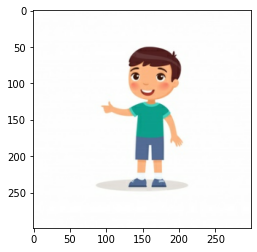

TITULO DE LA IMAGEN: a little girl in a red outfit is playing in a red toy car


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    try:
        from urllib.request import urlretrieve  # Python 3
    except ImportError:
        from urllib import urlretrieve  # Python 2

    sample_img = os.path.basename(img_url)
    urllib.request.urlretrieve(img_url,sample_img)
 
    # Leer la imagen
    sample_img = read_image(sample_img)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pasar la imagen al CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pasar las caracteristicas de la imagen al Transformer Encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generar el titulo de la imagen mediante el Transformer Encoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("TITULO DE LA IMAGEN:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())


# Mostrar el resultado
generate_caption()

### Métricas

La metricas se realizo al ejecutar el Entrenamiento de modelos con la siguiente Parametrizacon:

* BATCH_SIZE = 16
* EPOCHS = 5

Ejecutando en forma secuencial (sin GPU) demora más de 3 horas.

Ejecutando en forma paralela (con GPU) demora 15 minutos.

## Conclusiones
<!---
Palabras finales sobre la idea presentada. 
-->

El modelo comienza a generar subtítulos razonables después de algunas épocas. 

Para que este codigo se pueda ejecutar fácilmente, se ha entrenado con algunas restricciones, como un número mínimo de cabezas de atención, sin aumento de datos de imagen y sin programación de la tasa de aprendizaje. 

Para mejorar las predicciones, se puede intentar cambiar esta configuración de entrenamiento y encontrar un buen modelo para su caso de uso.

## Bibliografía
<!---
Toda referencia utilizada para confeccionar el ejercicio.
(incluyendo el código si tomaron la idea de otro lado)
-->

### Libros

<a href="http://so-unlam.com.ar/material-clase/HPC/Arquitecturas_de_computadores_avanzadas_(Modulo_1).pdf">Introducción a las
arquitecturas paralelas
</a>

<a href="http://so-unlam.com.ar/material-clase/HPC/Computaci%C3%B3n%20de%20alto%20desempe%C3%B1o%20en%20GPU.pdf">Computación de alto
desempeño en GPU</a>


### Videos Tutoriales

<a href="https://www.youtube.com/watch?v=inN8seMm7UI">Comienza a usar Google Colaboratory (Coding TensorFlow)</a>

<a href="https://www.youtube.com/watch?v=PitcORQSjNM">Getting Started with TensorFlow in Google Colaboratory (Coding TensorFlow)</a>


### Páginas Web

[1] <a href="https://www.netapp.com/es/data-storage/high-performance-computing/what-is-hpc/">¿Qué es la computación de alto rendimiento?</a>

[2] <a href="https://www.netapp.com/es/artificial-intelligence/what-is-machine-learning/">¿Qué es el aprendizaje automático?</a>

[3] <a href="https://www.tensorflow.org/?hl=es-419">TensorFlow</a>

[4] <a href="https://keras.io/">Keras</a>


### Ejemplos de códigos utilizados

<a href="https://keras.io/examples/vision/image_captioning/">Subtítulos de imágenes </a>